In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xtrack as xt
import xcoll as xc
import xpart as xp
import xobjects as xo

In [2]:
def remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2):
    "Remove apertures of off-momentum BPMs which give flanges as bottlenecks"
    tt = line.get_table()
    tw = line.twiss()
    mask_disp = 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx > 0.025
    mask_bpm = ['bp' in name for name in tt.name]
    mask_aper = np.array(['aper' in name for name in tt.name])
    offmom_bpms = tt.name[mask_disp & mask_bpm & ~mask_aper]
    aper_to_remove = [f'{name}{suffix}' for name in offmom_bpms for suffix in ('.a_aper', '.b_aper')]
    line.remove(aper_to_remove)

def install_tidp(line, block_mvt=29e-3):
    tidp_ap_tot = 147e-3
    line.discard_tracker()
    tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
    line.collimators.install(names=['tidp.11434'], elements=[tidp])
    return tidp

def install_tcsm(line, gap=5):
    tcsm = xc.EverestCollimator(length=1.83, gap=gap, material=xc.materials.Carbon) # length is 1.83
    line.collimators.install(names=['tcsm.51932'], elements=[tcsm])
    return tcsm

# Test time-dependant variables

In [3]:
# #find time per turn
# line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
# line.build_tracker()
# part = xp.generate_matched_gaussian_bunch(nemitt_x=2e-6,
#                                           nemitt_y=2e-6,
#                                           sigma_z=0.224, num_particles=1, line=line)
# print(line.ref['t_turn_s']._value)
# line.enable_time_dependent_vars=True
# line.track(part, num_turns=2, with_progress=True)
# time_per_turn =line.ref['t_turn_s']._value
# print(time_per_turn)
time_per_turn = 2.305894738364788e-05

In [ ]:
num_particles = 1000
num_turns = 3000
plane = 'H'
amplitude_adt = 0.07
start_at_turn=1000
nemitt_x = 2e-6
nemitt_y = 2e-6
time_per_turn = 2.305894738364788e-05
total_crab_voltage = 1e6
ramping_turns = 200

In [36]:
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')

env = line.env
#crab cavities: acfcah.61738 and acfcah.61739
crab1 = xt.CrabCavity(crab_voltage=0, frequency = line['actcse.31632'].frequency, lag=0)
crab2 = xt.CrabCavity(crab_voltage=0, frequency = line['actcse.31632'].frequency, lag=0)
env.elements['acfcah.61738'] = crab1
env.elements['acfcah.61739'] = crab2
tt = line.get_table()

remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)
tidp = install_tidp(line, block_mvt=29e-3)
tcsm = install_tcsm(line)

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

In [37]:
line['cc_voltage_ramping'] =  total_crab_voltage / (ramping_turns * time_per_turn) * line.ref['t_turn_s']
line['acfcah.61738'].crab_voltage = 'cc_voltage_ramping'
line['acfcah.61739'].crab_voltage = 'cc_voltage_ramping'

In [38]:
tw = line.twiss()
line.collimators.assign_optics(twiss=tw, nemitt_x=nemitt_x, nemitt_y=nemitt_y)

In [39]:
part = xp.generate_matched_gaussian_bunch(nemitt_x=nemitt_x,
                                          nemitt_y=nemitt_y,
                                          sigma_z=0.224, num_particles=num_particles, line=line)

*** Maximum RMS bunch length 0.2333663781336932m.
... distance to target bunch length: -2.2228e-01
... distance to target bunch length: 4.5424e-03
... distance to target bunch length: 4.3382e-03
... distance to target bunch length: -6.6565e-03
... distance to target bunch length: 2.0203e-03
... distance to target bunch length: -5.7185e-04
... distance to target bunch length: 1.0779e-04
... distance to target bunch length: 4.7891e-06
... distance to target bunch length: -2.0504e-09
... distance to target bunch length: 9.6490e-08
--> Bunch length: 0.22399999794961262
--> Emittance: 0.34347649813344366


KeyboardInterrupt: 

In [ ]:
line.enable_time_dependent_vars=True

line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))
line.scattering.enable()
line.track(part, num_turns=ramping_turns+1, with_progress=True)
print(line['acfcah.61738'].crab_voltage)
print(line['acfcah.61739'].crab_voltage)

line['cc_voltage_ramping'] =  total_crab_voltage
line.enable_time_dependent_vars=False
print(line['acfcah.61738'].crab_voltage)
print(line['acfcah.61739'].crab_voltage)
line.track(part, num_turns=num_turns, with_progress=True)
line.scattering.disable()

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/300 [00:00<?, ?it/s]

1000000.0
1000000.0
1000000.0
1000000.0


Tracking:   0%|          | 0/3000 [00:00<?, ?it/s]

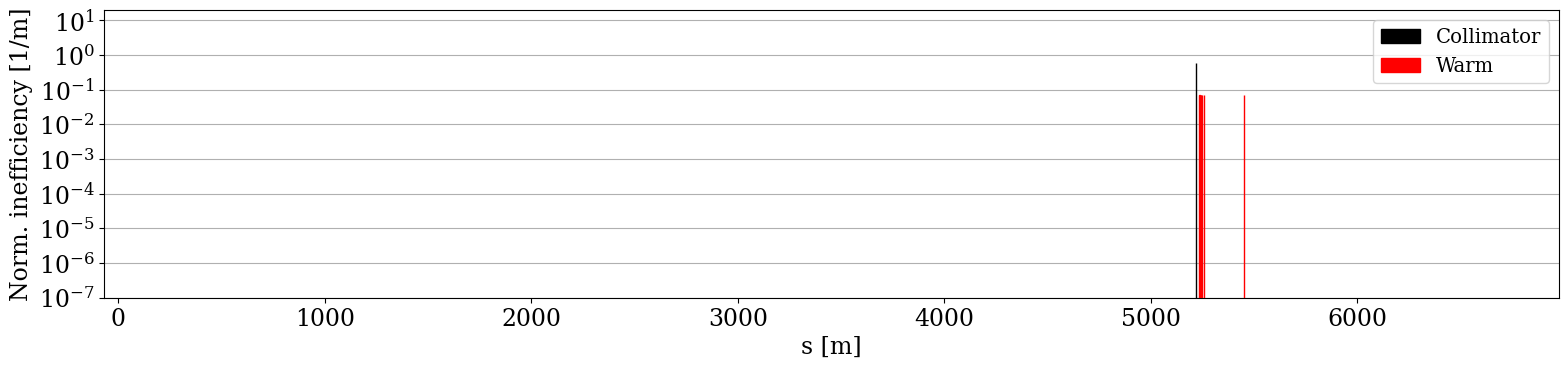

(<Figure size 1600x400 with 1 Axes>,
 <Axes: xlabel='s [m]', ylabel='Norm. inefficiency [1/m]'>)

In [ ]:
ThisLM = xc.LossMap(line = line, line_is_reversed=False, part=part, interpolation=False)
ThisLM.plot()

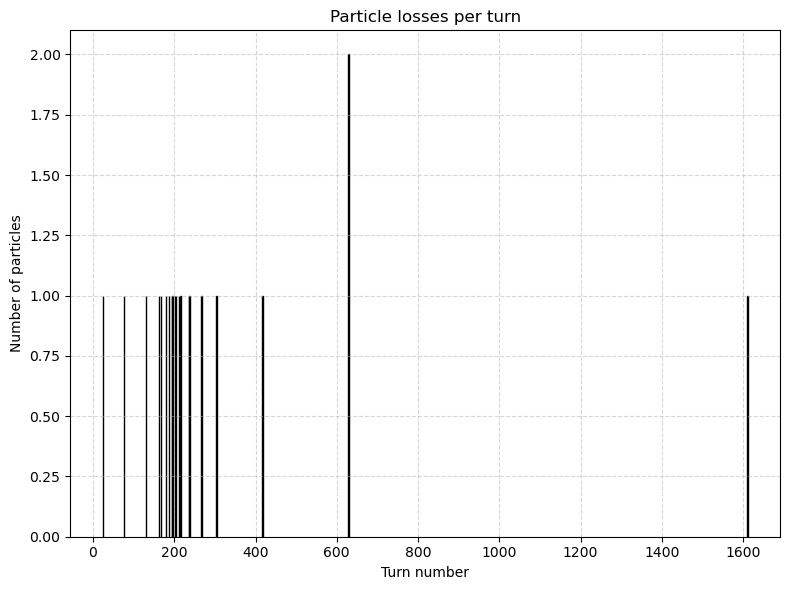

In [ ]:
plt.close('all')
mask = part.state > 0
unique_turns, counts = np.unique(part.at_turn[~mask], return_counts=True)

fig, ax = plt.subplots(figsize=(8, 6))
# Plot histogram-like bar chart
ax.bar(unique_turns, counts, width=1.0, edgecolor='black')
ax.set_xlabel("Turn number")
ax.set_ylabel("Number of particles")
ax.set_title("Particle losses per turn")
ax.grid(True, linestyle='--', alpha=0.5)
fig.tight_layout()
plt.show()

In [ ]:
np.unique(part.state, return_counts=True)

(array([-331,    0,    1]), array([ 15,   6, 979]))

# Test blowup 
Do we see improvement?
When to start the blowup? Immediately after ramping or still wait a few turns? How does start_at_turn work?

In [151]:
num_particles = 10000
num_turns = 3000
plane = 'H'
amplitude_adt = 0.08
start_at_turn= 500
nemitt_x = 2e-6
nemitt_y = 2e-6
time_per_turn = 2.305894738364788e-05
total_crab_voltage = 1e6
ramping_turns = 100

In [152]:
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')

env = line.env
#crab cavities: acfcah.61738 and acfcah.61739
crab1 = xt.CrabCavity(crab_voltage=0, frequency = line['actcse.31632'].frequency, lag=0)
crab2 = xt.CrabCavity(crab_voltage=0, frequency = line['actcse.31632'].frequency, lag=0)
env.elements['acfcah.61738'] = crab1
env.elements['acfcah.61739'] = crab2
tt = line.get_table()

remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)
tidp = install_tidp(line, block_mvt=29e-3)
tcsm = install_tcsm(line)

line['cc_voltage_ramping'] =  total_crab_voltage / (ramping_turns * time_per_turn) * line.ref['t_turn_s']
line['acfcah.61738'].crab_voltage = 'cc_voltage_ramping'
line['acfcah.61739'].crab_voltage = 'cc_voltage_ramping'

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

In [153]:
# #errors
# env = line.env
# env.vars.default_to_zero = False

# env.vars.update(dict(
#     b3a=-2.8e-03,# +/- 5.7e-04
#     b3b=1.6e-03,# +/- 3.2e-04

#     b5a=-7.9e+00,# +/- 5.4e-01
#     b5b=-6.8e+00,# +/- 1.5e+00

#     b7a=8.8e+04, # +/- 2.6e+04
#     b7b=1.7e+05, # +/- 0.8e+05

#     b3ar=0.0, #b3a*0.25,
#     b3br=0.0, #b3b*0.25,

#     b5ar=0.0, #b5a*0.25,
#     b5br=0.0, #b5b*0.25,

#     b7ar=0.0, #b7a*0.25,
#     b7br=0.0, #b7b*0.25,
# ))

# tw0 = line.twiss4d()

# tt = line.get_table()
# tt_bend = tt.rows[(tt.element_type=='Bend') | (tt.element_type=='RBend')]
# tt_mba = tt_bend.rows['mba.*']
# tt_mbb = tt_bend.rows['mbb.*']

# # Generate random normal variables
# np.random.seed(0)

# env['on_error'] = 0

# line.extend_knl_ksl(order=7, element_names=list(tt_mba.name) + list(tt_mbb.name))

# for tt, family in zip([tt_mba, tt_mbb], ['a', 'b']):
#     for order in [3, 5, 7]:
#         rand_values = np.random.normal(0, 1, size=len(tt))
#         for ii, nn in enumerate(tt_mba.name):
#             new_expr = env.new_expr(
#                 f'(b{order}{family} + b{order}{family}r*{rand_values[ii]}) * on_error')
#             env[nn].knl[order - 1] += new_expr

# env['on_error'] = 0
# tw_err_off = line.twiss4d()
# env['on_error'] = 1
# tw_err_on = line.twiss4d()

In [154]:
adt = xc.BlowUp.install(line, name=f'adt_{plane}_blowup', at_s=line.get_s_position('adkcv.32171'), plane=plane, stop_at_turn=num_turns,
                        amplitude=amplitude_adt, use_individual_kicks=False, start_at_turn=start_at_turn)

tw = line.twiss()
line.collimators.assign_optics(twiss=tw, nemitt_x=nemitt_x, nemitt_y=nemitt_y)

In [155]:
part = xp.generate_matched_gaussian_bunch(nemitt_x=nemitt_x,
                                          nemitt_y=nemitt_y,
                                          sigma_z=0.224, num_particles=num_particles, line=line)
part_init = part.copy()

*** Maximum RMS bunch length 0.2333663781336932m.
... distance to target bunch length: -2.2228e-01
... distance to target bunch length: 4.5424e-03
... distance to target bunch length: 4.3382e-03
... distance to target bunch length: -6.6565e-03
... distance to target bunch length: 2.0203e-03
... distance to target bunch length: -5.7185e-04
... distance to target bunch length: 1.0779e-04
... distance to target bunch length: 4.7891e-06
... distance to target bunch length: -2.0504e-09
... distance to target bunch length: 9.6490e-08
--> Bunch length: 0.22399999794961262
--> Emittance: 0.34347649813344366


In [ ]:
line.enable_time_dependent_vars=True
adt.calibrate_by_emittance(nemitt=nemitt_x, twiss=tw)

line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))
line.scattering.enable()
line.track(part, num_turns=101, with_progress=True)
print(line['acfcah.61738'].crab_voltage)
print(line['acfcah.61739'].crab_voltage)

line['cc_voltage_ramping'] =  total_crab_voltage
line.enable_time_dependent_vars=False
adt.activate()
line.track(part, num_turns=num_turns, with_progress=True)
adt.deactivate()
line.scattering.disable()

Compiling ContextCpu kernels...


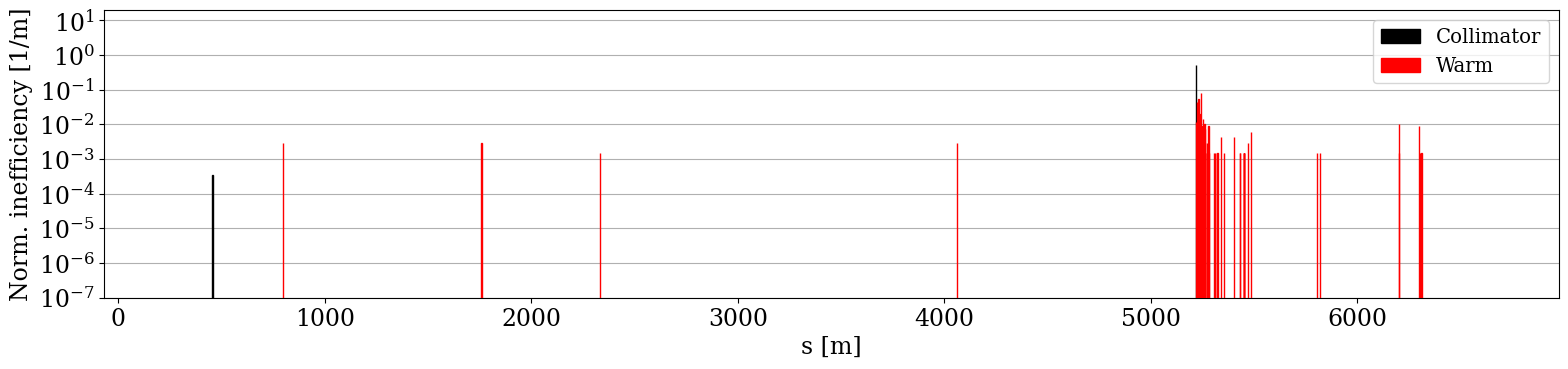

(<Figure size 1600x400 with 1 Axes>,
 <Axes: xlabel='s [m]', ylabel='Norm. inefficiency [1/m]'>)

In [ ]:
ThisLM = xc.LossMap(line = line, line_is_reversed=False, part=part, interpolation=False)
ThisLM.plot()

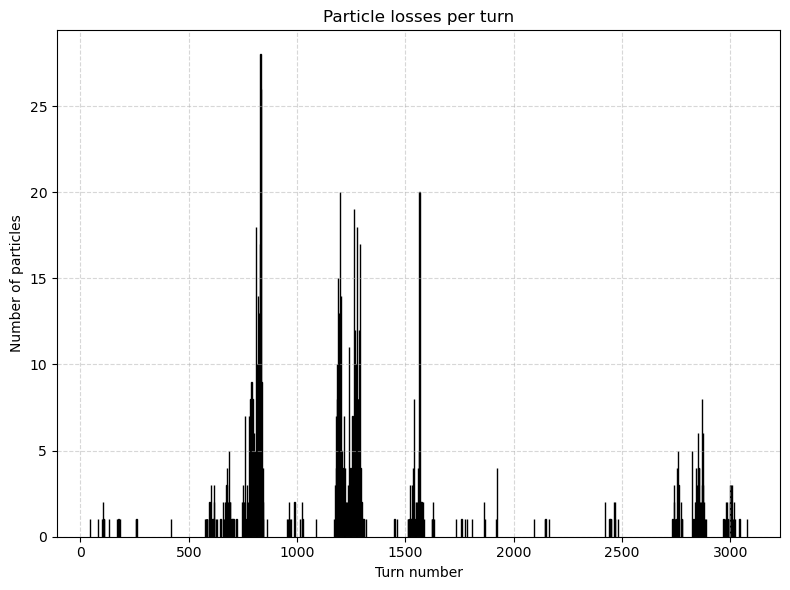

In [ ]:
plt.close('all')
mask = part.state > 0
unique_turns, counts = np.unique(part.at_turn[~mask], return_counts=True)

fig, ax = plt.subplots(figsize=(8, 6))
# Plot histogram-like bar chart
ax.bar(unique_turns, counts, width=1.0, edgecolor='black')
ax.set_xlabel("Turn number")
ax.set_ylabel("Number of particles")
ax.set_title("Particle losses per turn")
ax.grid(True, linestyle='--', alpha=0.5)
fig.tight_layout()
plt.savefig(f'plots/simple_blowup/start_{start_at_turn - 100}_after_ramp_adt_{amplitude_adt}_10000part.png', dpi=300)
plt.show()

In [146]:
np.unique(part.at_element, return_counts=True)

(array([    0,  2119,  3676,  8108, 10845, 18887, 24303, 24308, 24320,
        24324, 24328, 24336, 24342, 24344, 24348, 24352, 24358, 24362,
        24376, 24385, 24391, 24395, 24398, 24405, 24413, 24415, 24421,
        24423, 24427, 24429, 24431, 24433, 24435, 24437, 24439, 24443,
        24449, 24451, 24453, 24455, 24457, 24459, 24461, 24463, 24465,
        24467, 24469, 24479, 24487, 24523, 24527, 24529, 24533, 24555,
        24557, 24690, 24700, 24734, 24744, 24746, 24822, 24910, 25139,
        25283, 25285, 25389, 25391, 25395, 25397, 25401, 25499, 25559,
        27112, 27175, 29033, 29049, 29430, 29434, 29463, 29471]),
 array([ 26,   1,   2,   2,   1,   2, 650,   8,  30,   2,  36,  14,   1,
          1,   1,   2,   2,   3,   1,  54,   6,   3,   6,   1,   5,   4,
          5,   5,   4,   6,   3,   2,  10,   2,   2,   2,   1,   2,   5,
          2,   3,   1,   3,   4,   3,   7,   5,   2,   1,   1,   2,   1,
          1,   1,   6,   1,   1,   1,   1,   1,   3,   1,   3,   1,   1,
 

In [147]:
elems, counts = np.unique(part.at_element, return_counts=True)

In [148]:
np.unique(part.state, return_counts=True)

(array([-331,    0,    1]), array([651, 323,  26]))

In [64]:
elems[6]

np.int64(24303)

In [66]:
line.element_names[24303]

np.str_('tcsm.51932')

In [67]:
counts

array([306,   1,   1,   2,   1,   6, 462,  11,  15,  20,  14,   2,   4,
         1,   1,   2,   1,   2,  36,   2,   5,   1,   2,   3,   2,   4,
         1,   2,   5,   1,   2,   2,   3,   4,   1,   4,   1,   3,   3,
         4,   2,   1,   1,   6,   3,   1,   1,   1,   2,   2,   1,   7,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   3,   3,   2,   3,   1,   2,   1])

In [82]:
len(part_init.x[idxs])

1000